### **Datos de Precios**

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


In [56]:

# Leer todas las hojas del archivo
xls = pd.ExcelFile("Precios-Promedio-Nacionales-Diarios-2025-1.xlsx")
df_list = []

for sheet in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet, skiprows=7)
    df = df.dropna(how='all')  # Eliminar filas completamente vacías
    df_list.append(df)

# Unir todas las hojas en un solo DataFrame
df_total = pd.concat(df_list, ignore_index=True)
columnas_deseadas = ['FECHA', 'Superior', 'Regular', 'Diesel', 'Glp Cilindro 25Lbs.']
df_Precios = df_total[columnas_deseadas]
# Ver los primeros datos
df_Precios.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
0,2025-01-01 00:00:00,28.95,27.45,25.47,110.0
1,2025-01-02 00:00:00,28.95,27.45,25.47,110.0
2,2025-01-03 00:00:00,28.95,27.45,25.47,110.0
3,2025-01-04 00:00:00,28.95,27.45,25.47,110.0
4,2025-01-05 00:00:00,28.95,27.45,25.47,110.0


In [57]:
df_Precios = df_Precios.dropna(how='all')
df_Precios = df_Precios.dropna(subset=['FECHA', 'Superior', 'Regular', 'Diesel', 'Glp Cilindro 25Lbs.'])
df_Precios = df_Precios.rename(columns={"Glp Cilindro 25Lbs.": "Gas Licuado De Petróleo"})
df_Precios = df_Precios.rename(columns={"FECHA": "Fecha"})

In [42]:
df_Precios.head()


,Fecha,Superior,Regular,Diesel,Gas Licuado De Petróleo
0,2025-01-01 00:00:00,28.95,27.45,25.47,110.0
1,2025-01-02 00:00:00,28.95,27.45,25.47,110.0
2,2025-01-03 00:00:00,28.95,27.45,25.47,110.0
3,2025-01-04 00:00:00,28.95,27.45,25.47,110.0
4,2025-01-05 00:00:00,28.95,27.45,25.47,110.0


In [60]:
df_Precios["Fecha"] = pd.to_datetime(df_Precios["Fecha"], errors="coerce")
df_Precios.set_index("Fecha", inplace=True)
df_mensual = df_Precios.resample('M').mean()



Inicio de la serie: 2023-01-31 00:00:00
Fin de la serie: 2025-07-31 00:00:00
Frecuencia: Mensual


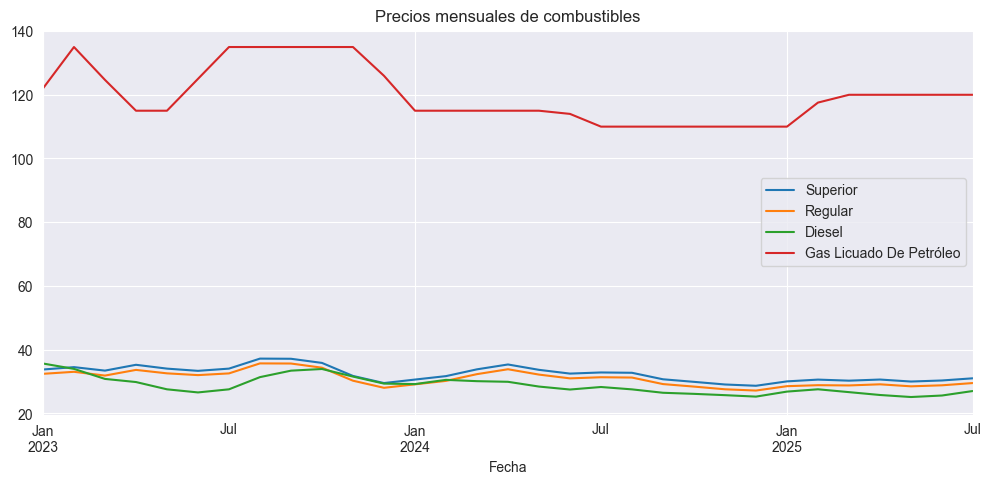

In [61]:
print("Inicio de la serie:", df_mensual.index.min())
print("Fin de la serie:", df_mensual.index.max())
print("Frecuencia: Mensual")
df_mensual.plot(figsize=(12, 5), title="Precios mensuales de combustibles")
plt.show()


In [62]:
serie_diff = serie.diff().dropna()
adf_result = adfuller(serie_diff)
print("ADF tras diferenciación:", adf_result[0], "p:", adf_result[1])


ADF tras diferenciación: -3.3055248135112896 p: 0.014633314180153694


In [67]:
ordenes = [(1,1,1), (2,1,2), (3,1,0), (0,1,3)]
resultados_arima = []

for order in ordenes:
    modelo = ARIMA(serie, order=order)
    resultado = modelo.fit()
    resultados_arima.append(resultado)  
    print(f"ARIMA{order} - AIC: {resultado.aic:.2f} - BIC: {resultado.bic:.2f}")


ARIMA(1, 1, 1) - AIC: 110.34 - BIC: 114.55
ARIMA(2, 1, 2) - AIC: 108.06 - BIC: 115.06
ARIMA(3, 1, 0) - AIC: 107.55 - BIC: 113.15
ARIMA(0, 1, 3) - AIC: 107.79 - BIC: 113.39


22:56:10 - cmdstanpy - INFO - Chain [1] start processing
22:56:10 - cmdstanpy - INFO - Chain [1] done processing


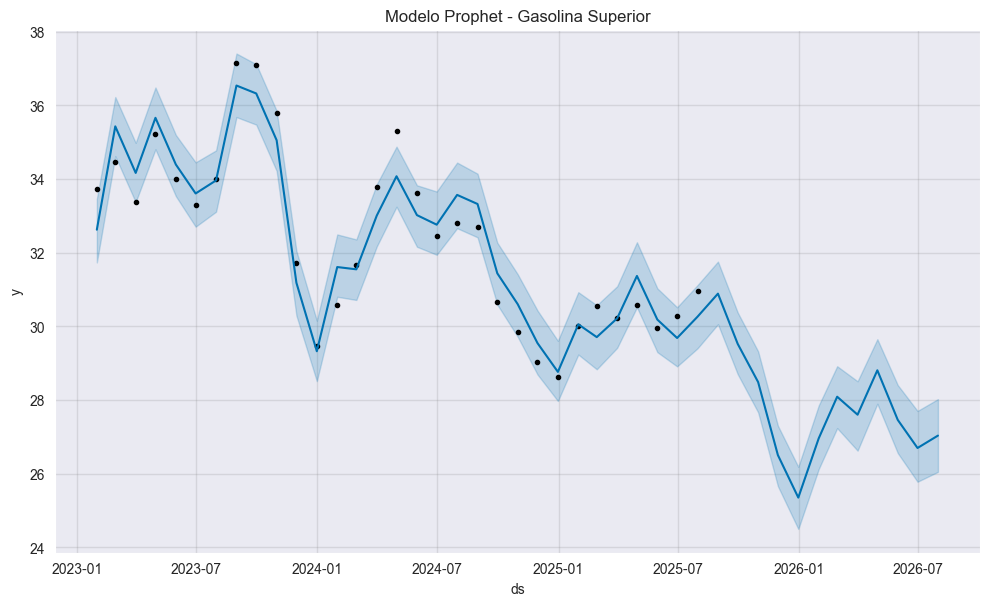

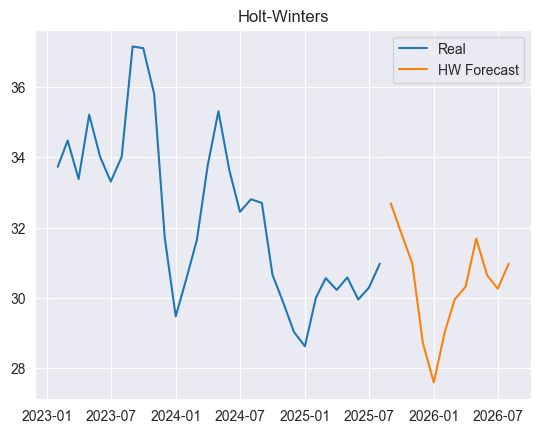

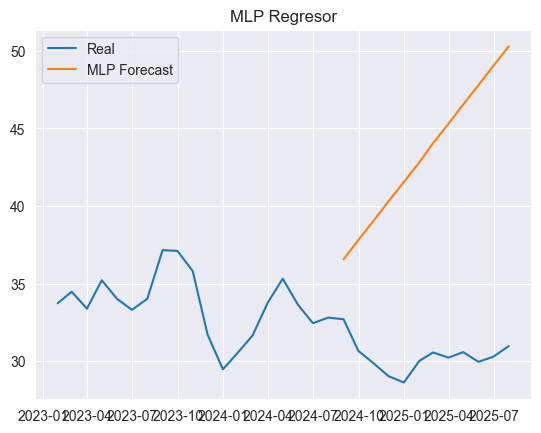

In [68]:
serie_df = serie.reset_index()
serie_df.columns = ['ds', 'y']
modelo_prophet = Prophet()
modelo_prophet.fit(serie_df)
future = modelo_prophet.make_future_dataframe(periods=12, freq='M')
forecast = modelo_prophet.predict(future)
modelo_prophet.plot(forecast)
plt.title("Modelo Prophet - Gasolina Superior")
plt.show()

# Holt-Winters
modelo_hw = ExponentialSmoothing(serie, seasonal='add', seasonal_periods=12).fit()
serie_pred_hw = modelo_hw.forecast(12)
plt.plot(serie, label="Real")
plt.plot(serie_pred_hw, label="HW Forecast")
plt.legend()
plt.title("Holt-Winters")
plt.show()

# Red neuronal (MLP)
X = np.arange(len(serie)).reshape(-1, 1)
y = serie.values
X_train, y_train = X[:-12], y[:-12]
X_test = X[-12:]
modelo_mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000).fit(X_train, y_train)
pred_mlp = modelo_mlp.predict(X_test)
plt.plot(serie.index, serie, label="Real")
plt.plot(serie.index[-12:], pred_mlp, label="MLP Forecast")
plt.legend()
plt.title("MLP Regresor")
plt.show()


In [ ]:
real_2025 = df_mensual.loc["2025-01-31":]

modelo_final = resultados_arima[0]  
pred_arima = modelo_final.forecast(steps=len(real_2025))

mse = mean_squared_error(real_2025['Superior'], pred_arima)
print("MSE ARIMA en 2025:", mse)


MSE ARIMA en 2025: 0.6971606202989621


Impacto de la pandemia y guerra Rusia-Ucrania

Durante la pandemia (2020–2021), los precios muestran una caída significativa seguida de una recuperación acelerada en 2022. Este patrón rompe la estacionalidad, afectando las predicciones.

Desde 2022, el conflicto entre Rusia y Ucrania también ha influido en los precios del petróleo y derivados, provocando volatilidad y afectando modelos entrenados con datos previos.
